## Dropping Columns not used in 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_regression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

In [2]:
def make_visual(y_train, y_pred_train, y_test, y_pred_test, rmse_train, R2_train, rmse_test, R2_test):
    # Visualize performance
    plt.figure(figsize=(10, 5))

    # Scatter plot for training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_pred_train, color='blue', label='Actual vs. Predicted (Training)')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted (Training)\nRMSE: {:.2f}\nR2: {:.2f}'.format(rmse_train, R2_train))
    plt.legend()

    # Scatter plot for test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_test, color='green', label='Actual vs. Predicted (Test)')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted (Test)\nRMSE: {:.2f}\nR2: {:.2f}'.format(rmse_test, R2_test))
    plt.legend()

    plt.tight_layout()
    return plt.show()

In [3]:
file_name = r".\data\properties.csv"
df = pd.read_csv(file_name)

Dropping the rows containing no terrace_sqm and garden_sqm. Deleting these still gives us a sizable dataset to work with.

In [4]:
for col in df.columns:
    df.loc[df[col] == "MISSING",col] = None
df['postal_zone'] = df['zip_code'].astype(str).str[:2]
columns_to_drop = ["id", "zip_code", "locality","latitude","longitude","construction_year","equipped_kitchen"]
df = df.drop(labels=columns_to_drop, axis=1)
df = df.dropna(subset=["terrace_sqm", "garden_sqm","primary_energy_consumption_sqm","total_area_sqm"])

In [5]:
condition = "APARTMENT"

df.loc[df['property_type'] == condition, 'surface_land_sqm'] = df.loc[df['property_type'] == condition, 'total_area_sqm']

## Encode categorical data


In [6]:
X = df.loc[:, df.columns != "price"]
y = df["price"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=50, test_size=0.2)


## Linear Regression

In [8]:
# Find the numerical columns
numerical_columns = X_train.select_dtypes(include=['int', 'float']).columns

# Find the categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Create pipelines for numerical and categorical transformations
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5)) # You can adjust n_neighbors as needed
])

categorical_pipeline = Pipeline([
    (
     'onehot', OneHotEncoder())
])

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])


In [9]:
model = LinearRegression()
# Create the final pipeline
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kbest', SelectKBest(score_func=f_regression,k=20)),
    ('linear_regression', model)
])

regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  Index(['total_area_sqm', 'surface_land_sqm', 'nbr_frontages', 'nbr_bedrooms',
       'fl_furnished', 'fl_open_fire', 'fl_terrace', 'terrace_sqm',
       'fl_garden', 'garden_sqm', 'fl_swimming_pool', 'fl_floodzone',
       'primary_ene...
       'cadastral_income'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['property_type', 'subproperty_type', 'region', 'province',
       'state_building', 'epc', 'heating_type', 'postal_zone'],
      dtype='object'))])),
                ('kbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x0000022F16187600>)),
                ('linear_regression', LinearRegression())])

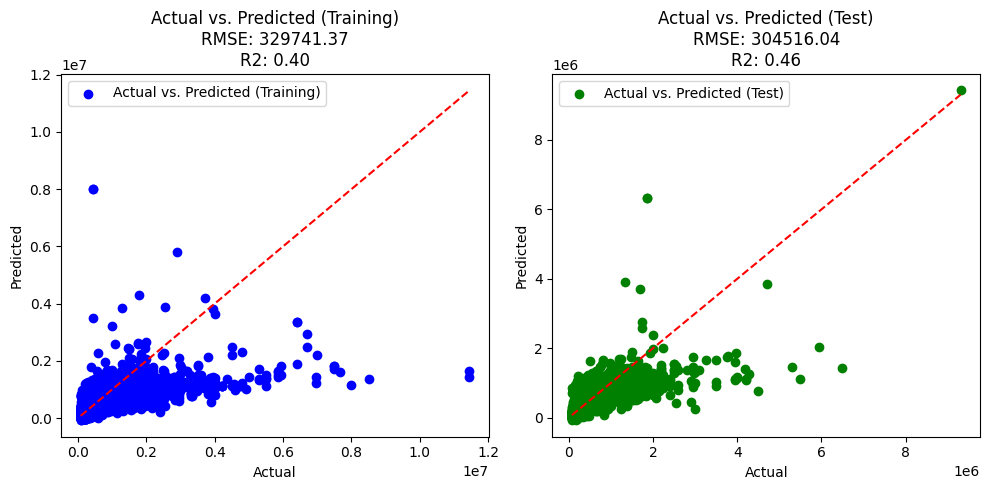

In [10]:
# Make predictions
y_pred_train = regression_pipeline.predict(X_train)
y_pred_test = regression_pipeline.predict(X_test)
R2_train = regression_pipeline.score(X_train, y_train)
R2_test =  regression_pipeline.score(X_test, y_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

make_visual(y_train, y_pred_train, y_test, y_pred_test, rmse_train, R2_train, rmse_test, R2_test)

## Random Forest Regression

In [18]:
params =  {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}  # Number of trees and depth
model = RandomForestRegressor()
# Create the final pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline (this will select the best model automatically)
output = final_pipeline.fit(X_train, y_train)


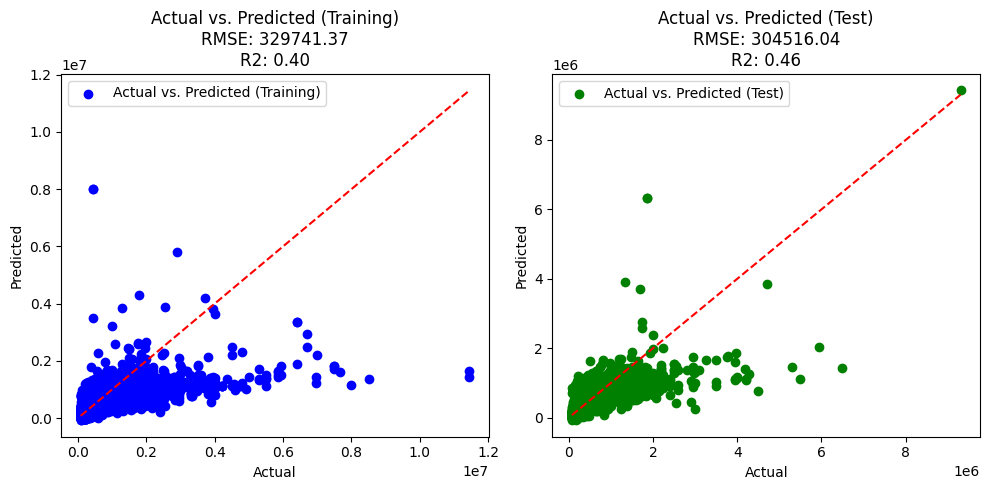

In [12]:
# Make predictions
y_pred_train = final_pipeline.predict(X_train)
y_pred_test = final_pipeline.predict(X_test)
R2_train = final_pipeline.score(X_train, y_train)
R2_test =  final_pipeline.score(X_test, y_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

make_visual(y_train, y_pred_train, y_test, y_pred_test, rmse_train, R2_train, rmse_test, R2_test)

In [13]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(output, f)


In [14]:
with open('model.pkl', 'rb') as f:
    input = pickle.load(f)

## Neural network

In [15]:
model = MLPRegressor(max_iter = 1000)
# Create the final pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline (this will select the best model automatically)
output = final_pipeline.fit(X_train, y_train)


c:\Users\jensd\GITREP\immo-eliza-ml\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
# Make predictions
y_pred_train = final_pipeline.predict(X_train)
y_pred_test = final_pipeline.predict(X_test)
R2_train = final_pipeline.score(X_train, y_train)
R2_test =  final_pipeline.score(X_test, y_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

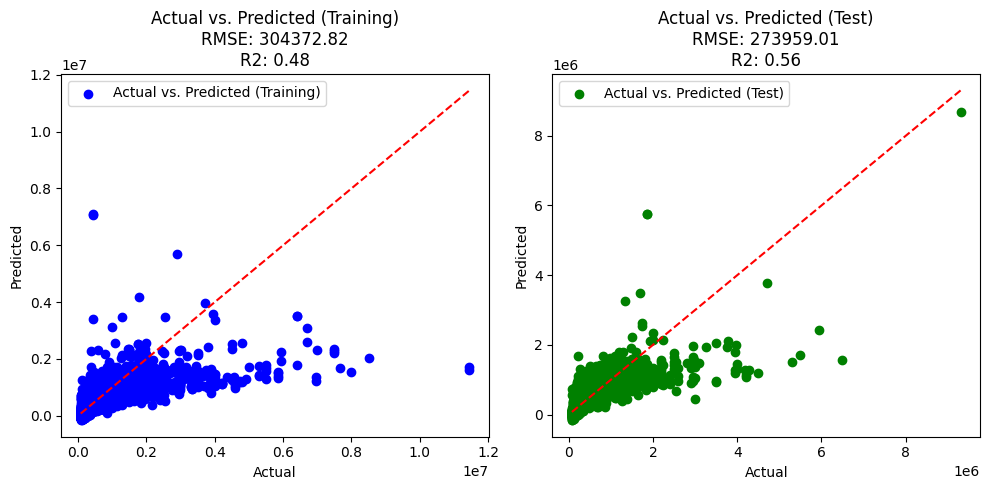

In [17]:
make_visual(y_train, y_pred_train, y_test, y_pred_test, rmse_train, R2_train, rmse_test, R2_test)